In [1]:
from glob import glob
import os
import sys
import inspect

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from utils.plotting import goes_figure

In [2]:
dcc_files = sorted(glob('/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_2018*_120000.nc'))
print(len(dcc_files))

297


In [3]:
print(len(dcc_files))
dcc_files

297


['/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180213_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180214_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180215_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180216_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180218_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180219_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180220_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180221_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/goes/goes16/dcc_detect/validation_dccs_20180222_120000.nc',
 '/gws/nopw/j04/eo_shared_data_vol1/satellite/

In [4]:
flash2core = []
flash2wvd = []
flash2anvil = []
core2flash = []
wvd2flash = []
anvil2flash = []

for f in dcc_files:
    print(f, end='\r')
    with xr.open_dataset(f) as ds:
        flash2core.append(ds.flash_core_distance.data)
        flash2wvd.append(ds.flash_wvd_distance.data)
        flash2anvil.append(ds.flash_anvil_distance.data)
        core2flash.append(ds.core_glm_distance.data[ds.core_margin_flag.data])
        wvd2flash.append(ds.wvd_glm_distance.data[ds.wvd_margin_flag.data])
        anvil2flash.append(ds.anvil_glm_distance.data[ds.anvil_margin_flag.data])

flash2core = np.concatenate(flash2core)
flash2wvd = np.concatenate(flash2wvd)
flash2anvil = np.concatenate(flash2anvil)
core2flash = np.concatenate(core2flash)
wvd2flash = np.concatenate(wvd2flash)
anvil2flash = np.concatenate(anvil2flash)

n_glm = flash2core.size
n_core = core2flash.size
n_wvd = wvd2flash.size
n_anvil = anvil2flash.size


In [5]:
print(n_glm, n_core, n_wvd, n_anvil)

49013358 76725 323618 14717


In [6]:
core_pod = np.sum(flash2core<=10)/n_glm
wvd_pod = np.sum(flash2wvd<=10)/n_glm
anvil_pod = np.sum(flash2anvil<=10)/n_glm

print(core_pod, wvd_pod, anvil_pod)

0.23086000351169572 0.9947988464695685 0.9303598215000898


In [7]:
core_far = np.sum(core2flash>10)/n_core
wvd_far = np.sum(wvd2flash>10)/n_wvd
anvil_far = np.sum(anvil2flash>10)/n_anvil

print(core_far, wvd_far, anvil_far)

0.27000325839035516 0.734381276690419 0.3529251885574506


In [8]:
core_f1 = 2*core_pod*(1-core_far)/(core_pod+1-core_far)
wvd_f1 = 2*wvd_pod*(1-wvd_far)/(wvd_pod+1-wvd_far)
anvil_f1 = 2*anvil_pod*(1-anvil_far)/(anvil_pod+1-anvil_far)

print(core_f1, wvd_f1, anvil_f1)

0.3507849659945861 0.41928517323888204 0.7632803204629344


In [20]:
validation_ds = xr.Dataset(
    data_vars=dict(
        flash_core_distance=(('flash',), flash2core), 
        flash_wvd_distance=(('flash',), flash2wvd), 
        flash_anvil_distance=(('flash',), flash2anvil), 
        core_flash_distance=(('core',), core2flash), 
        wvd_flash_distance=(('wvd',), wvd2flash), 
        anvil_flash_distance=(('anvil',), anvil2flash), 
        core_pod=(tuple(), core_pod), 
        wvd_pod=(tuple(), wvd_pod), 
        anvil_pod=(tuple(), anvil_pod), 
        core_far=(tuple(), core_far), 
        wvd_far=(tuple(), wvd_far), 
        anvil_far=(tuple(), anvil_far), 
        core_f1=(tuple(), core_f1), 
        wvd_f1=(tuple(), wvd_f1), 
        anvil_f1=(tuple(), anvil_f1), 
        n_glm=(tuple(), n_glm), 
        n_core=(tuple(), n_core), 
        n_wvd=(tuple(), n_wvd), 
        n_anvil=(tuple(), n_anvil), 
        )
    )
validation_ds.to_netcdf('./data/validation_data.nc')

In [25]:
core_pod_hist = np.histogram(validation_ds.flash_core_distance, bins=40, range=[0,40])[0] / validation_ds.n_glm.data
wvd_pod_hist = np.histogram(validation_ds.flash_wvd_distance, bins=40, range=[0,40])[0] / validation_ds.n_glm.data
anvil_pod_hist = np.histogram(validation_ds.flash_anvil_distance, bins=40, range=[0,40])[0] / validation_ds.n_glm.data

core_far_hist = np.histogram(validation_ds.core_flash_distance, bins=40, range=[0,40])[0] / validation_ds.n_core.data
wvd_far_hist = np.histogram(validation_ds.wvd_flash_distance, bins=40, range=[0,40])[0] / validation_ds.n_wvd.data
anvil_far_hist = np.histogram(validation_ds.anvil_flash_distance, bins=40, range=[0,40])[0] / validation_ds.n_anvil.data


markers:
n = 76725
POD = 0.23086000351169572
FAR = 0.27000325839035516
F1 score = 0.3507849659945861
WVD:
n = 323618
POD = 0.9947988464695685
FAR = 0.734381276690419
F1 score = 0.41928517323888204
anvil:
n = 14717
POD = 0.9303598215000898
FAR = 0.3529251885574506
F1 score = 0.7632803204629344
total GLM flashes:  49013358


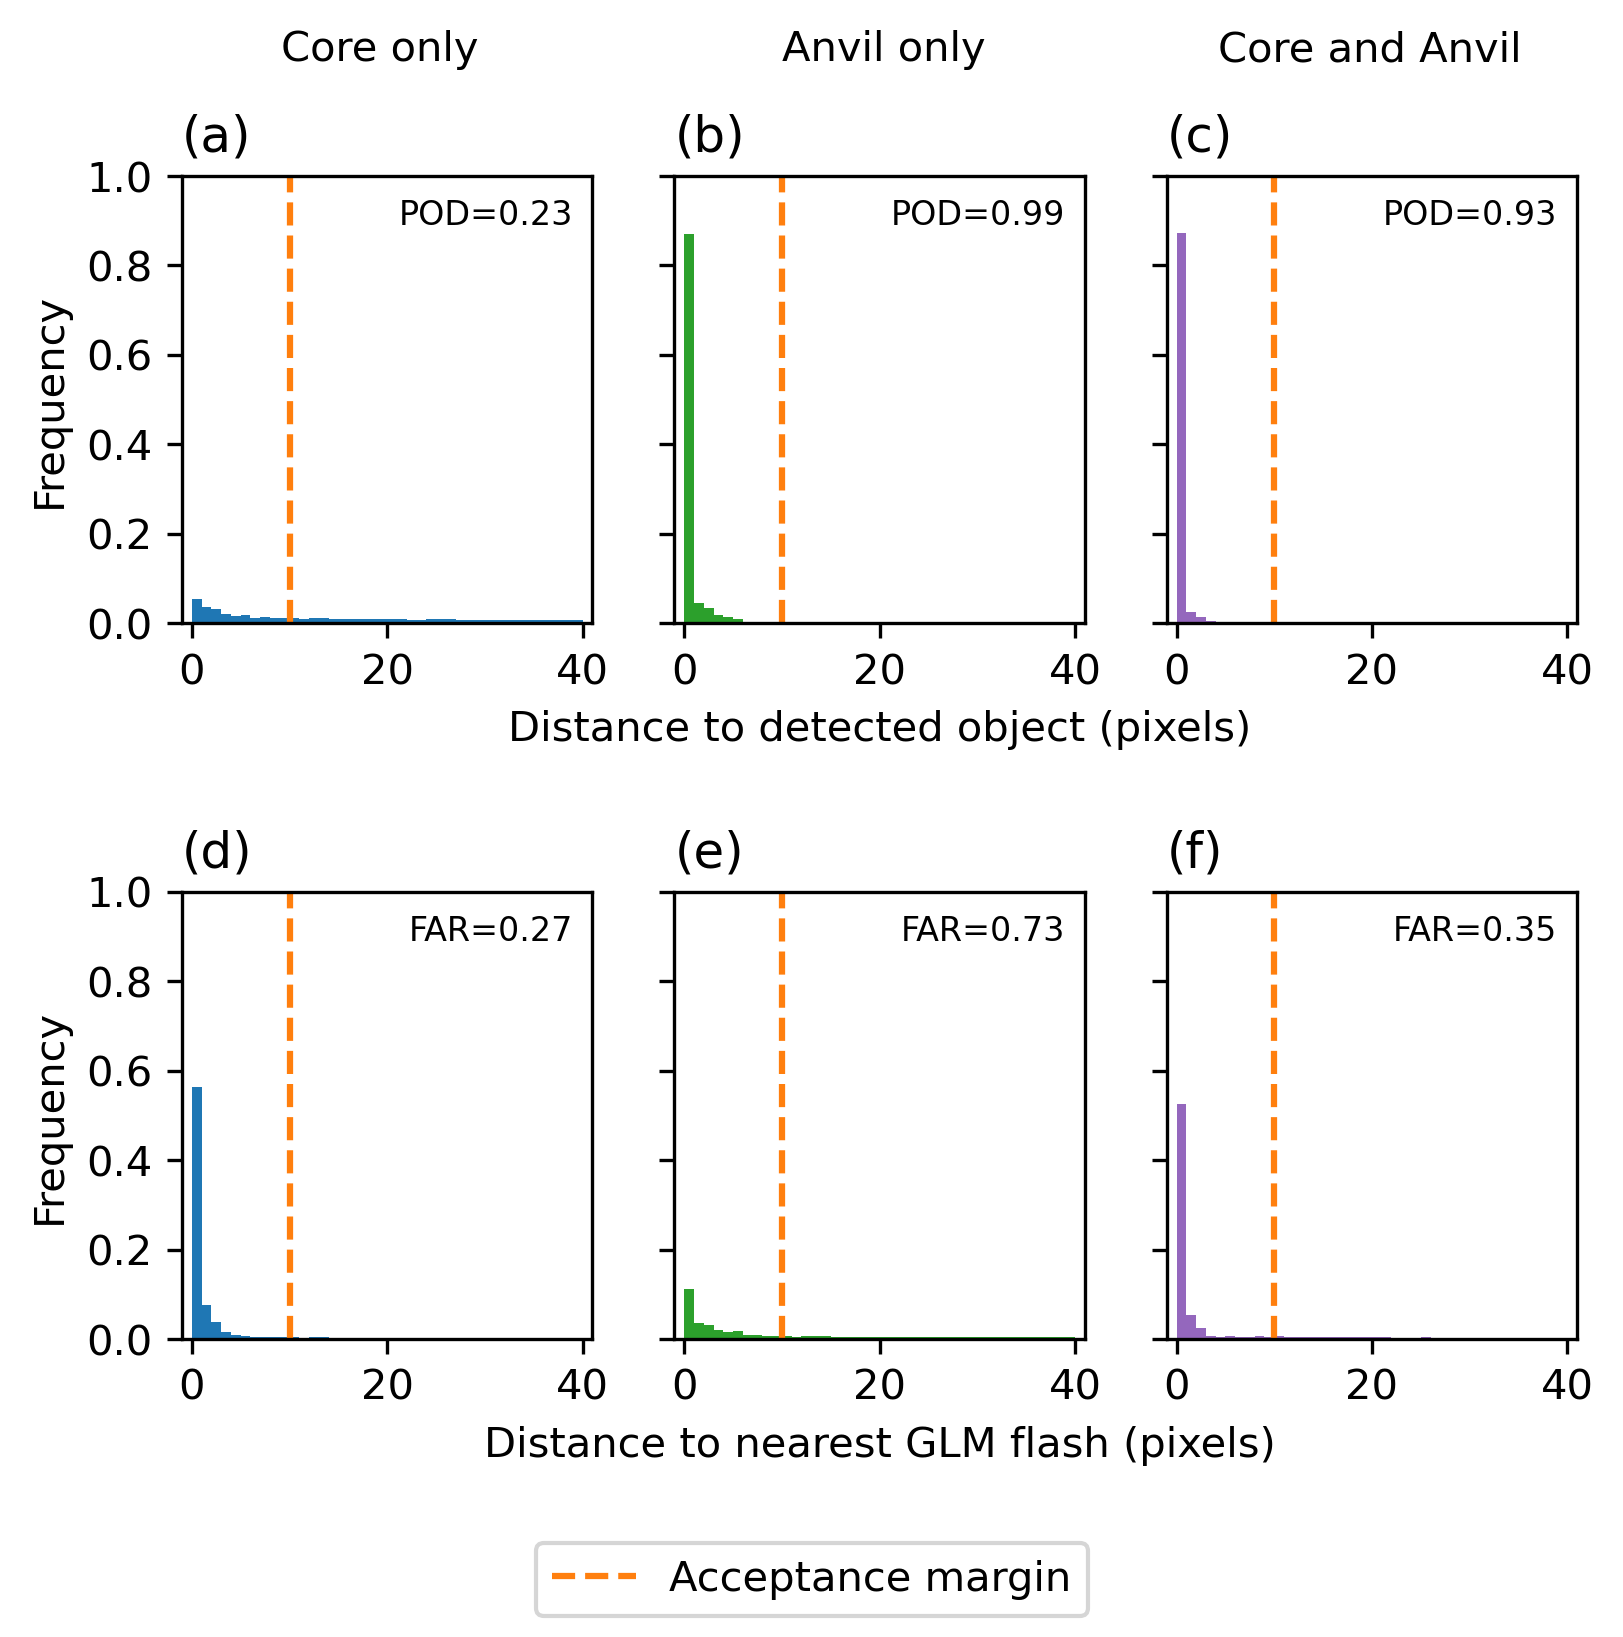

In [26]:
acceptance_margin = 10

fig = plt.figure(dpi=300, figsize=(6,5.5))

plt.subplot(231)
plt.bar(np.arange(0,40), core_pod_hist,
        width=1, align='edge')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('(a)', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')
plt.text(39,0.95,'POD='+str(np.round(validation_ds.core_pod.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(232)
plt.bar(np.arange(0,40), wvd_pod_hist,
        width=1, align='edge', color='C02')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to WVD')
plt.title('(b)', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
plt.xlabel('Distance to detected object (pixels)')
plt.text(39,0.95,
         'POD='+str(np.round(validation_ds.wvd_pod.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(233)
plt.bar(np.arange(0,40), anvil_pod_hist,
        width=1, align='edge', color='C04')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest anvil')
plt.title('(c)', loc='left')
# plt.ylabel('Frequency')
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to detected anvil (pixels)')
plt.text(39,0.95,
         'POD='+str(np.round(validation_ds.anvil_pod.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(234)
plt.bar(np.arange(0,40), core_far_hist,
        width=1, align='edge', color='C00')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('(d)', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(validation_ds.core_far.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)


plt.subplot(235)
plt.bar(np.arange(0,40), wvd_far_hist,
        width=1, align='edge', color='C02')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('WVD distance to nearest GLM flash')
plt.title('(e)', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
plt.xlabel('Distance to nearest GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(validation_ds.wvd_far.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(236)
plt.bar(np.arange(0,40), anvil_far_hist,
        width=1, align='edge', color='C04')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('Anvil distance to nearest GLM flash')
plt.title('(f)', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(validation_ds.anvil_far.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Acceptance margin'], loc='lower center')

fig.text(0.235, 0.95, 'Core only', ha='center', va='baseline')
fig.text(0.515, 0.95, 'Anvil only', ha='center', va='baseline')
fig.text(0.785, 0.95, 'Core and Anvil', ha='center', va='baseline')


# plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.85, left=0.075, right=0.95)
plt.subplots_adjust(hspace=0.6, bottom=0.175)

print('markers:')
print('n =', validation_ds.n_core.data)
print('POD =', validation_ds.core_pod.data)
print('FAR =', validation_ds.core_far.data)
print('F1 score =', validation_ds.core_f1.data)

print('WVD:')
print('n =', validation_ds.n_wvd.data)
print('POD =', validation_ds.wvd_pod.data)
print('FAR =', validation_ds.wvd_far.data)
print('F1 score =', validation_ds.wvd_f1.data)

print('anvil:')
print('n =', validation_ds.n_anvil.data)
print('POD =', validation_ds.anvil_pod.data)
print('FAR =', validation_ds.anvil_far.data)
print('F1 score =', validation_ds.anvil_f1.data)

print('total GLM flashes: ', int(validation_ds.n_glm.data))

plt.savefig('./figure09.pdf', bbox_inches='tight')
plt.savefig('./figure09.png', bbox_inches='tight')

In [27]:
validation_ds.close()